Homework 110 - Network Compression
===

> Author: Arvin Liu (r09922071@ntu.edu.tw), this colab is modified from ML2021-HW3

If you have any questions, feel free to ask: ntu-ml-2021spring-ta@googlegroups.com

## **Intro**

HW13 is about network compression

There are many types of Network/Model Compression,  here we introduce two:
* Knowledge Distillation
* Design Architecture


The process of this notebook is as follows: <br/>
1. Introduce depthwise, pointwise and group convolution in MobileNet.
2. Design the model of this colab
3. Introduce Knowledge-Distillation
4. Set up TeacherNet and it would be helpful in training


## **About the Dataset**  *(same as HW3)*

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
# ### This block is same as HW3 ###
# # Download the dataset
# # You may choose where to download the data.

# # Google Drive
# !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip
# # If you cannot successfully gdown, you can change a link. (Backup link is provided at the bottom of this colab tutorial).

# # Dropbox
# # !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# # MEGA
# # !sudo apt install megatools
# # !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# # Unzip the dataset.
# # This may take some time.
# !unzip -q food-11.zip

In [2]:
import os

for dirname, _, filenames in os.walk('./food-11'):
    if len(filenames) > 0:
        print(f"{dirname}: {len(filenames)} files.") # Show the file amounts in each split.

./food-11/validation/04: 60 files.
./food-11/validation/02: 60 files.
./food-11/validation/08: 60 files.
./food-11/validation/03: 60 files.
./food-11/validation/00: 60 files.
./food-11/validation/01: 60 files.
./food-11/validation/06: 60 files.
./food-11/validation/09: 60 files.
./food-11/validation/07: 60 files.
./food-11/validation/05: 60 files.
./food-11/validation/10: 60 files.
./food-11/testing/00: 3347 files.
./food-11/training/labeled/04: 280 files.
./food-11/training/labeled/02: 280 files.
./food-11/training/labeled/08: 280 files.
./food-11/training/labeled/03: 280 files.
./food-11/training/labeled/00: 280 files.
./food-11/training/labeled/01: 280 files.
./food-11/training/labeled/06: 280 files.
./food-11/training/labeled/09: 280 files.
./food-11/training/labeled/07: 280 files.
./food-11/training/labeled/05: 280 files.
./food-11/training/labeled/10: 280 files.
./food-11/training/unlabeled/00: 6786 files.


## **Import Packages**  *(same as HW3)*

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [3]:
### This block is same as HW3 ###
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm
import random
import inspect

# !nvidia-smi # list your current GPU

## **Dataset, Data Loader, and Transforms** *(similar to HW3)*

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

---
**The only diffference with HW3 is that the transform functions are different.**

In [4]:
from dataset import train_tfm, test_tfm
print(train_tfm)

print(test_tfm)

Compose(
    Resize(size=(142, 142), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomCrop(size=(128, 128), padding=None)
    ToTensor()
)
Compose(
    Resize(size=(142, 142), interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    ToTensor()
)


In [5]:
from dataset import get_unlabeled_set, get_loader

lines = inspect.getsource(get_unlabeled_set)
print(lines)

lines = inspect.getsource(get_loader)
print(lines)

train_loader, valid_loader, test_loader, train_set = get_loader()

def get_unlabeled_set(): 
    unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
    return unlabeled_set

def get_loader(batch_size = 64):
    ### This block is similar to HW3 ###
    # Batch size for training, validation, and testing.
    # A greater batch size usually gives a more stable gradient.
    # But the GPU memory is limited, so please adjust it carefully.

    # Construct datasets.
    # The argument "loader" tells how torchvision reads the data.
    train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
    valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
    
    test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

    # Construct data loaders.
    train_loader = DataLoader(train_set, batch_size=

# **Architecture / Model Design**
The following are types of convolution layer design that has fewer parameters.

## **Depthwise & Pointwise Convolution**
![](https://i.imgur.com/FBgcA0s.png)
> Blue: the connection between layers \
> Green: the expansion of **receptive field** \
> (reference: arxiv:1810.04231)

(a) normal convolution layer: It is fully connected. The difference between fully connected layer and fully connected convolution layer is the operation. (multiply --> convolution)

(b) Depthwise convolution layer(DW): You can consider each feature map pass through their own filter and then pass through pointwise convolution layer(PW) to combine the information of all pixels in feature maps.


(c) Group convolution layer(GC): Group the feature maps. Each group passes their filter then concate together. If group_size = input_feature_size, then GC becomes DC (channels are independent). If group_size = 1, then GC becomes fully connected.

<img src="https://i.imgur.com/Hqhg0Q9.png" width="500px">


## **Implementation details**
```python
# Regular Convolution, # of params = in_chs * out_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)

# Group Convolution, "groups" controls the connections between inputs and
# outputs. in_chs and out_chs must both be divisible by groups.
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding, groups=groups)

# Depthwise Convolution, out_chs=in_chs=groups, # of params = in_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs=in_chs, kernel_size, stride, padding, groups=in_chs)

# Pointwise Convolution, a.k.a 1 by 1 convolution, # of params = in_chs * out_chs
nn.Conv2d(in_chs, out_chs, 1)

# Merge Depthwise and Pointwise Convolution (without )
def dwpw_conv(in_chs, out_chs, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_chs, in_chs, kernels, stride, padding, groups=in_chs),
        nn.Conv2d(in_chs, out_chs, 1),
    )
```

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers. You can take advatage of depthwise & pointwise convolution to make your model deeper, but still follow the size constraint.

In [6]:
# from baseline import StudentNet
from strong import StudentNet
lines = inspect.getsource(StudentNet)
print(lines)

class StudentNet(nn.Module):
    def __init__(self):
      super(StudentNet, self).__init__()

      # ---------- TODO ----------
      # Modify your model architecture

      self.cnn =  nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, 64, 3, 1, 0),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
            ),
            dwpw_conv(64, 128, 3, 1, 0),
            dwpw_conv(128, 256, 3, 1, 0),
           
            nn.Sequential(
                nn.Conv2d(256, 256, 3, 1, 0, groups=256),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 150, 1),
            ),
            # Here we adopt Global Average Pooling for various input size.
            nn.AdaptiveAvgPool2d((1, 1)),
      )
      self.fc = nn.Sequential(
        nn.Linear(150, 64),
        nn.ReLU(),
        nn.Linear(64, 11),
      )
      
    def forward(self, x):
      out = self.cnn(x)
      out = out.view(o

## **Model Analysis**

Use `torchsummary` to get your model architecture (screenshot or pasting text are allowed.) and numbers of 
parameters, these two information should be submit to your NTU Cool questions.

Note that the number of parameters **should not greater than 100,000**, or you'll get penalty in this homework.


In [7]:
from torchsummary import summary

student_net = StudentNet()
summary(student_net, (3, 128, 128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           1,792
       BatchNorm2d-2         [-1, 64, 126, 126]             128
              ReLU-3         [-1, 64, 126, 126]               0
         MaxPool2d-4           [-1, 64, 63, 63]               0
            Conv2d-5           [-1, 64, 61, 61]             640
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8          [-1, 128, 61, 61]           8,320
         MaxPool2d-9          [-1, 128, 30, 30]               0
           Conv2d-10          [-1, 128, 28, 28]           1,280
      BatchNorm2d-11          [-1, 128, 28, 28]             256
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]          33,024
        MaxPool2d-14          [-1, 256,

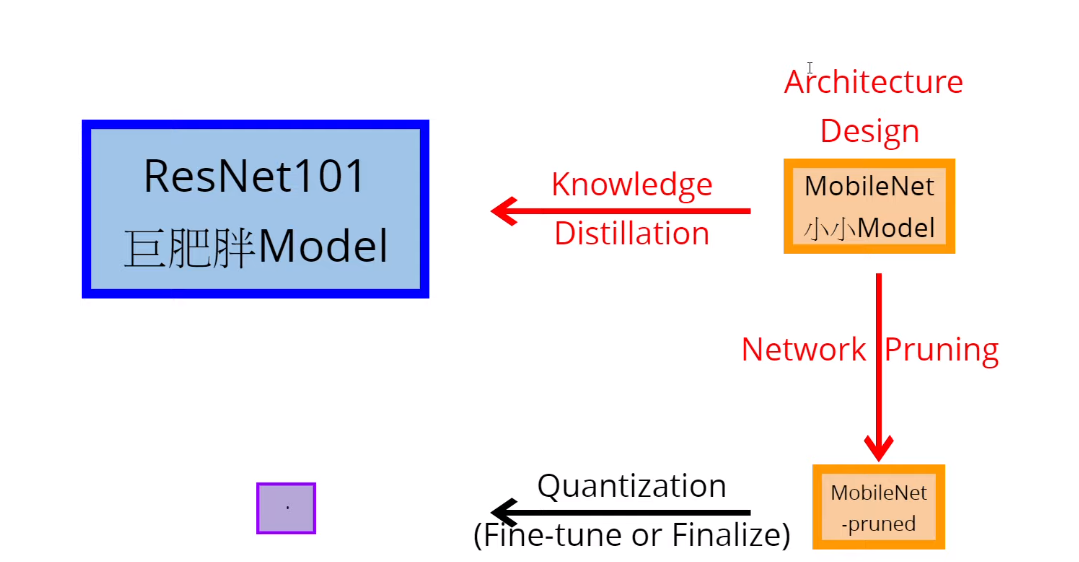

## **Knowledge Distillation**

<img src="https://i.imgur.com/H2aF7Rv.png=100x" width="500px">

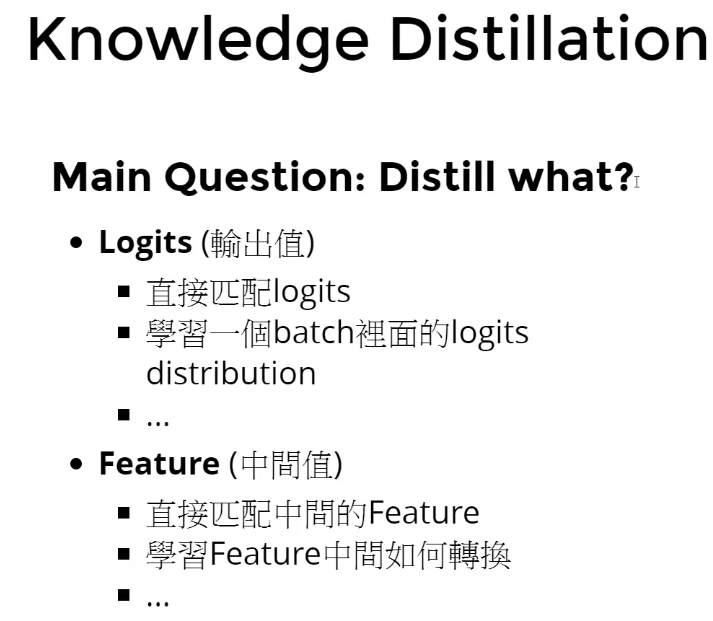

Since we have a learned big model, let it teach the other small model. In implementation, let the training target be the prediction of big model instead of the ground truth.

## **Why it works?**
* If the data is not clean, then the prediction of big model could ignore the noise of the data with wrong labeled.
* The labels might have some relations. Number 8 is more similar to 6, 9, 0 than 1, 7, for example.


## **How to implement?**
* $Loss = \alpha T^2 \times KL(\frac{\text{Teacher's Logits}}{T} || \frac{\text{Student's Logits}}{T}) + (1-\alpha)(\text{Original Loss})$
* Note that the logits here should have passed softmax.

In [8]:
from loss import loss_fn_kd
lines = inspect.getsource(loss_fn_kd)
print(lines)

def loss_fn_kd(outputs, labels, teacher_outputs, alpha=0.5, temperature=20):
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha) 
    # ---------- TODO ----------
    # Complete soft loss in knowledge distillation
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    soft_loss = alpha * pow(temperature, 2) * kl_loss(F.log_softmax(outputs/temperature, dim=1), \
                                                 F.softmax(teacher_outputs/temperature, dim=1))
    return hard_loss + soft_loss



## **Teacher Model Setting**
We provide a well-trained teacher model to help you knowledge distillation to student model.
Note that if you want to change the transform function, you should consider  if suitable for this well-trained teacher model.
* If you cannot successfully gdown, you can change a link. (Backup link is provided at the bottom of this colab tutorial).


In [9]:
# Download teacherNet
# !gdown --id '1zH1x39Y8a0XyOORG7TWzAnFf_YPY8e-m' --output teacher_net.ckpt

# Train teacherNet
# !python teacher_net.py

# Load teacherNet
from utils import load_teacherNet
lines = inspect.getsource(load_teacherNet)
print(lines)

teacher_net = load_teacherNet()
teacher_net

def load_teacherNet():
    # Load teacherNet
    teacher_net = models.resnet18(pretrained=False)
    num_ftrs = teacher_net.fc.in_features
    teacher_net.fc = nn.Linear(num_ftrs, 11)

    teacher_net.load_state_dict(torch.load('./teacher_model.ckpt'))
    teacher_net.eval()
    return teacher_net



/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Generate Pseudo Labels in Unlabeled Data**

Since we have a well-trained model, we can use this model to predict pseudo-labels and help the student network train well. Note that you 
**CANNOT** use well-trained model to pseudo-label the test data. 


---

**AGAIN, DO NOT USE TEST DATA FOR PURPOSE OTHER THAN INFERENCING**

* Because If you use teacher network to predict pseudo-labels of the test data, you can only use student network to overfit these pseudo-labels without train/unlabeled data. In this way, your kaggle accuracy will be as high as the teacher network, but the fact is that you just overfit the test data and your true testing accuracy is very low. 
* These contradict the purpose of these assignment (network compression); therefore, you should not misuse the test data.
* If you have any concerns, you can email us.


In [10]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
student_net = student_net.to(device)
teacher_net = teacher_net.to(device)

# Whether to do pseudo label.
do_semi = True

from dataset import get_pseudo_labels, semi_dataloader
lines = inspect.getsource(get_pseudo_labels)
print(lines)

lines = inspect.getsource(semi_dataloader)
print(lines)

if do_semi:
    train_loader = semi_dataloader(teacher_net, train_set)



def get_pseudo_labels(dataset, model, batch_size = 64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    pseudo_labels = []
    for batch in tqdm(loader):
        # A batch consists of image data and corresponding labels.
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))
            pseudo_labels.append(logits.argmax(dim=-1).detach().cpu())
        # Obtain the probability distributions by applying softmax on logits.
    pseudo_labels = torch.cat(pseudo_labels)
    # Update the labels by replacing with pseudo labels.
    for idx, ((img, _), pseudo_label) in enumerate(zip(dataset.samples, pseudo_labels)):
        dataset.samples[idx] = (img, pseudo_label.item())
    return dataset

def semi_dataloader(teacher_net, train_set, batch_size = 64):
    # Generate new trainloader with unlabeled set.
    unlabeled_s

100%|█████████████████████████████████████████████| 107/107 [00:36<00:00,  2.92it/s]


## **Training** *(similar to HW3)*

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

---
**The only diffference with HW3 is that you should use loss in  knowledge distillation.**




In [11]:
from script import train
lines = inspect.getsource(train)
print(lines)

# The number of training epochs.
n_epochs = 500
train(teacher_net, student_net, train_loader, valid_loader, n_epochs)

def train(teacher_net, student_net, train_loader, valid_loader, n_epochs):
    # For the classification task, we use cross-entropy as the measurement of performance.
    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
    optimizer = torch.optim.Adam(student_net.parameters(), lr=1e-3, weight_decay=1e-4)    

    best_acc = 0.0

    best_model_path = './best_model.ckpt'
    last_path = './last_model.ckpt'

    for epoch in range(n_epochs):
        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        student_net.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data.

100%|█████████████████████████████████████████████| 154/154 [01:06<00:00,  2.31it/s]


[ Train | 001/500 ] loss = 4.10872, acc = 0.28724


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


saving model with acc 0.329
[ Valid | 001/500 ] loss = 4.22310, acc = 0.32879


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 002/500 ] loss = 3.48749, acc = 0.38464


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


saving model with acc 0.370
[ Valid | 002/500 ] loss = 3.78312, acc = 0.36970


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.57it/s]


[ Train | 003/500 ] loss = 3.20840, acc = 0.43476


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


saving model with acc 0.445
[ Valid | 003/500 ] loss = 3.40372, acc = 0.44545


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.52it/s]


[ Train | 004/500 ] loss = 3.02147, acc = 0.46013


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 004/500 ] loss = 3.31626, acc = 0.43636


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.53it/s]


[ Train | 005/500 ] loss = 2.85981, acc = 0.48935


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


saving model with acc 0.467
[ Valid | 005/500 ] loss = 3.19088, acc = 0.46667


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.54it/s]


[ Train | 006/500 ] loss = 2.73423, acc = 0.49848


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


saving model with acc 0.471
[ Valid | 006/500 ] loss = 3.22789, acc = 0.47121


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.53it/s]


[ Train | 007/500 ] loss = 2.65284, acc = 0.51664


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


saving model with acc 0.497
[ Valid | 007/500 ] loss = 3.09352, acc = 0.49697


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.52it/s]


[ Train | 008/500 ] loss = 2.55272, acc = 0.53003


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


saving model with acc 0.529
[ Valid | 008/500 ] loss = 2.87112, acc = 0.52879


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.54it/s]


[ Train | 009/500 ] loss = 2.47815, acc = 0.54332


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


saving model with acc 0.530
[ Valid | 009/500 ] loss = 2.78908, acc = 0.53030


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.53it/s]


[ Train | 010/500 ] loss = 2.41626, acc = 0.55012


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


saving model with acc 0.538
[ Valid | 010/500 ] loss = 2.77221, acc = 0.53788


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.53it/s]


[ Train | 011/500 ] loss = 2.35742, acc = 0.55722


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 011/500 ] loss = 2.74667, acc = 0.53485


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.55it/s]


[ Train | 012/500 ] loss = 2.30771, acc = 0.56382


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


saving model with acc 0.542
[ Valid | 012/500 ] loss = 2.63769, acc = 0.54242


100%|█████████████████████████████████████████████| 154/154 [01:00<00:00,  2.53it/s]


[ Train | 013/500 ] loss = 2.26077, acc = 0.57437


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


saving model with acc 0.562
[ Valid | 013/500 ] loss = 2.71535, acc = 0.56212


100%|█████████████████████████████████████████████| 154/154 [01:09<00:00,  2.22it/s]


[ Train | 014/500 ] loss = 2.22097, acc = 0.58066


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.03it/s]


saving model with acc 0.602
[ Valid | 014/500 ] loss = 2.34836, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 015/500 ] loss = 2.16826, acc = 0.57955


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 015/500 ] loss = 2.45101, acc = 0.55152


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 016/500 ] loss = 2.12558, acc = 0.58969


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 016/500 ] loss = 2.51064, acc = 0.54091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 017/500 ] loss = 2.09816, acc = 0.59547


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 017/500 ] loss = 2.99857, acc = 0.50152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 018/500 ] loss = 2.07763, acc = 0.59679


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


saving model with acc 0.623
[ Valid | 018/500 ] loss = 2.34269, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 019/500 ] loss = 2.04193, acc = 0.60491


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 019/500 ] loss = 2.52838, acc = 0.54545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 020/500 ] loss = 2.02620, acc = 0.60582


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


[ Valid | 020/500 ] loss = 2.40514, acc = 0.53030


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 021/500 ] loss = 1.97195, acc = 0.61749


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


[ Valid | 021/500 ] loss = 2.14299, acc = 0.60455


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 022/500 ] loss = 1.97142, acc = 0.60907


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 022/500 ] loss = 2.20076, acc = 0.59091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 023/500 ] loss = 1.92036, acc = 0.62328


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 023/500 ] loss = 2.39572, acc = 0.57879


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 024/500 ] loss = 1.93566, acc = 0.61942


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 024/500 ] loss = 2.17707, acc = 0.59394


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 025/500 ] loss = 1.88570, acc = 0.62429


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 025/500 ] loss = 2.10777, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 026/500 ] loss = 1.85779, acc = 0.63038


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


saving model with acc 0.638
[ Valid | 026/500 ] loss = 2.03966, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 027/500 ] loss = 1.87373, acc = 0.63454


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 027/500 ] loss = 2.25403, acc = 0.57424


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 028/500 ] loss = 1.83468, acc = 0.63484


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 028/500 ] loss = 2.10130, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.51it/s]


[ Train | 029/500 ] loss = 1.78876, acc = 0.64752


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 029/500 ] loss = 2.07078, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 030/500 ] loss = 1.79956, acc = 0.63728


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 030/500 ] loss = 2.12527, acc = 0.60758


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 031/500 ] loss = 1.77245, acc = 0.64894


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 031/500 ] loss = 1.98602, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.48it/s]


[ Train | 032/500 ] loss = 1.78166, acc = 0.64286


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 032/500 ] loss = 2.20590, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.52it/s]


[ Train | 033/500 ] loss = 1.78619, acc = 0.64286


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 033/500 ] loss = 2.07294, acc = 0.59848


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 034/500 ] loss = 1.75226, acc = 0.65047


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 034/500 ] loss = 2.07779, acc = 0.59091


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.48it/s]


[ Train | 035/500 ] loss = 1.71311, acc = 0.65310


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


[ Valid | 035/500 ] loss = 2.04473, acc = 0.59394


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 036/500 ] loss = 1.71221, acc = 0.65280


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 036/500 ] loss = 2.12217, acc = 0.60000


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 037/500 ] loss = 1.71231, acc = 0.65219


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


[ Valid | 037/500 ] loss = 1.97482, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 038/500 ] loss = 1.70231, acc = 0.65513


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 038/500 ] loss = 2.01524, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 039/500 ] loss = 1.68072, acc = 0.66467


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 039/500 ] loss = 1.88643, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 040/500 ] loss = 1.67163, acc = 0.65970


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 040/500 ] loss = 1.97571, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 041/500 ] loss = 1.66286, acc = 0.66366


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 041/500 ] loss = 2.01534, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 042/500 ] loss = 1.65102, acc = 0.66224


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 042/500 ] loss = 2.06264, acc = 0.59242


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 043/500 ] loss = 1.65521, acc = 0.67238


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 043/500 ] loss = 1.96248, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 044/500 ] loss = 1.62810, acc = 0.67015


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 044/500 ] loss = 1.95744, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 045/500 ] loss = 1.63912, acc = 0.66700


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 045/500 ] loss = 1.87780, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 046/500 ] loss = 1.61589, acc = 0.67056


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 046/500 ] loss = 1.91415, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 047/500 ] loss = 1.59860, acc = 0.67735


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 047/500 ] loss = 1.83021, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 048/500 ] loss = 1.59934, acc = 0.67492


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


saving model with acc 0.639
[ Valid | 048/500 ] loss = 1.85511, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 049/500 ] loss = 1.57232, acc = 0.68273


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 049/500 ] loss = 1.86692, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 050/500 ] loss = 1.57976, acc = 0.67624


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 050/500 ] loss = 1.86587, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 051/500 ] loss = 1.57180, acc = 0.67877


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 051/500 ] loss = 1.89137, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 052/500 ] loss = 1.56758, acc = 0.67725


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 052/500 ] loss = 1.98842, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 053/500 ] loss = 1.58598, acc = 0.67482


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 053/500 ] loss = 1.96220, acc = 0.60000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 054/500 ] loss = 1.53596, acc = 0.68486


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


saving model with acc 0.641
[ Valid | 054/500 ] loss = 1.93400, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 055/500 ] loss = 1.54519, acc = 0.68446


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 055/500 ] loss = 1.81538, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 056/500 ] loss = 1.54914, acc = 0.68131


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 056/500 ] loss = 1.84893, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:15<00:00,  2.04it/s]


[ Train | 057/500 ] loss = 1.53685, acc = 0.69267


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.10it/s]


[ Valid | 057/500 ] loss = 1.84831, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:06<00:00,  2.31it/s]


[ Train | 058/500 ] loss = 1.52948, acc = 0.68679


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


[ Valid | 058/500 ] loss = 1.84974, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 059/500 ] loss = 1.52290, acc = 0.69196


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 059/500 ] loss = 2.25179, acc = 0.55152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 060/500 ] loss = 1.52086, acc = 0.68334


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 060/500 ] loss = 1.95860, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 061/500 ] loss = 1.50491, acc = 0.68882


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


saving model with acc 0.658
[ Valid | 061/500 ] loss = 1.77783, acc = 0.65758


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 062/500 ] loss = 1.49817, acc = 0.69044


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 062/500 ] loss = 1.90302, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 063/500 ] loss = 1.51063, acc = 0.69815


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 063/500 ] loss = 1.78838, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 064/500 ] loss = 1.48226, acc = 0.69947


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 064/500 ] loss = 1.82288, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 065/500 ] loss = 1.47518, acc = 0.69724


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 065/500 ] loss = 1.86560, acc = 0.60606


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 066/500 ] loss = 1.47379, acc = 0.69430


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 066/500 ] loss = 2.02984, acc = 0.59848


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 067/500 ] loss = 1.45913, acc = 0.70221


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 067/500 ] loss = 1.82565, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 068/500 ] loss = 1.46798, acc = 0.69734


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 068/500 ] loss = 2.26096, acc = 0.55909


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 069/500 ] loss = 1.47140, acc = 0.70252


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 069/500 ] loss = 1.74346, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 070/500 ] loss = 1.46727, acc = 0.70008


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 070/500 ] loss = 1.82569, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 071/500 ] loss = 1.46043, acc = 0.70384


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 071/500 ] loss = 2.02380, acc = 0.59394


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 072/500 ] loss = 1.45281, acc = 0.70262


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 072/500 ] loss = 1.74603, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 073/500 ] loss = 1.44050, acc = 0.70231


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 073/500 ] loss = 1.79766, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 074/500 ] loss = 1.42483, acc = 0.70931


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 074/500 ] loss = 1.89501, acc = 0.60909


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 075/500 ] loss = 1.42269, acc = 0.70678


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 075/500 ] loss = 1.76042, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 076/500 ] loss = 1.40612, acc = 0.71124


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 076/500 ] loss = 1.85464, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 077/500 ] loss = 1.44937, acc = 0.70678


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 077/500 ] loss = 1.98455, acc = 0.58182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 078/500 ] loss = 1.42206, acc = 0.70607


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 078/500 ] loss = 2.00577, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 079/500 ] loss = 1.43168, acc = 0.70789


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 079/500 ] loss = 1.89770, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 080/500 ] loss = 1.42644, acc = 0.70982


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 080/500 ] loss = 1.83009, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 081/500 ] loss = 1.41191, acc = 0.70982


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 081/500 ] loss = 1.97709, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 082/500 ] loss = 1.40679, acc = 0.71550


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.46it/s]


[ Valid | 082/500 ] loss = 1.89827, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 083/500 ] loss = 1.41481, acc = 0.71175


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 083/500 ] loss = 1.79612, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.51it/s]


[ Train | 084/500 ] loss = 1.39262, acc = 0.71500


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 084/500 ] loss = 1.96867, acc = 0.59697


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 085/500 ] loss = 1.38592, acc = 0.72463


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 085/500 ] loss = 1.74891, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 086/500 ] loss = 1.38737, acc = 0.71692


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 086/500 ] loss = 1.91950, acc = 0.58939


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 087/500 ] loss = 1.37774, acc = 0.71631


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 087/500 ] loss = 1.77707, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 088/500 ] loss = 1.39200, acc = 0.71489


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 088/500 ] loss = 1.92635, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 089/500 ] loss = 1.34823, acc = 0.72474


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 089/500 ] loss = 1.86382, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 090/500 ] loss = 1.38810, acc = 0.71246


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 090/500 ] loss = 1.88610, acc = 0.58939


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 091/500 ] loss = 1.36688, acc = 0.72149


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 091/500 ] loss = 1.81025, acc = 0.60606


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 092/500 ] loss = 1.36215, acc = 0.71733


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 092/500 ] loss = 1.70909, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 093/500 ] loss = 1.36950, acc = 0.72271


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 093/500 ] loss = 2.18120, acc = 0.57424


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 094/500 ] loss = 1.36153, acc = 0.72494


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 094/500 ] loss = 1.82915, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 095/500 ] loss = 1.36228, acc = 0.72545


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 095/500 ] loss = 1.82674, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 096/500 ] loss = 1.36047, acc = 0.72666


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 096/500 ] loss = 1.82731, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:07<00:00,  2.27it/s]


[ Train | 097/500 ] loss = 1.35836, acc = 0.72514


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 097/500 ] loss = 1.95034, acc = 0.59848


100%|█████████████████████████████████████████████| 154/154 [01:07<00:00,  2.28it/s]


[ Train | 098/500 ] loss = 1.35570, acc = 0.72555


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


[ Valid | 098/500 ] loss = 1.84870, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 099/500 ] loss = 1.34169, acc = 0.72778


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 099/500 ] loss = 1.71465, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 100/500 ] loss = 1.34210, acc = 0.72382


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 100/500 ] loss = 1.71200, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 101/500 ] loss = 1.34929, acc = 0.72443


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 101/500 ] loss = 1.82482, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 102/500 ] loss = 1.35571, acc = 0.71824


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 102/500 ] loss = 1.85105, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 103/500 ] loss = 1.31415, acc = 0.73174


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 103/500 ] loss = 1.76808, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 104/500 ] loss = 1.31762, acc = 0.73224


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 104/500 ] loss = 1.81228, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 105/500 ] loss = 1.33394, acc = 0.73224


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 105/500 ] loss = 1.70613, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 106/500 ] loss = 1.33613, acc = 0.72687


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 106/500 ] loss = 1.78623, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 107/500 ] loss = 1.31724, acc = 0.73417


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 107/500 ] loss = 1.74227, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 108/500 ] loss = 1.32775, acc = 0.73072


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 108/500 ] loss = 1.80614, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 109/500 ] loss = 1.30669, acc = 0.73498


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 109/500 ] loss = 1.82631, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 110/500 ] loss = 1.31984, acc = 0.73366


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 110/500 ] loss = 1.83075, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 111/500 ] loss = 1.30325, acc = 0.73407


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 111/500 ] loss = 1.77048, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 112/500 ] loss = 1.32009, acc = 0.73600


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 112/500 ] loss = 1.89212, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 113/500 ] loss = 1.28584, acc = 0.74036


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 113/500 ] loss = 1.76172, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.51it/s]


[ Train | 114/500 ] loss = 1.30858, acc = 0.73438


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 114/500 ] loss = 1.81273, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 115/500 ] loss = 1.29602, acc = 0.73772


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 115/500 ] loss = 1.83048, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 116/500 ] loss = 1.28971, acc = 0.74452


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 116/500 ] loss = 1.70104, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 117/500 ] loss = 1.28886, acc = 0.73640


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 117/500 ] loss = 1.80716, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 118/500 ] loss = 1.29123, acc = 0.74127


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 118/500 ] loss = 1.79399, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 119/500 ] loss = 1.28848, acc = 0.73833


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 119/500 ] loss = 1.69443, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 120/500 ] loss = 1.30396, acc = 0.73823


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 120/500 ] loss = 1.86190, acc = 0.61061


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 121/500 ] loss = 1.26879, acc = 0.74513


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 121/500 ] loss = 1.85882, acc = 0.60909


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 122/500 ] loss = 1.28396, acc = 0.74330


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 122/500 ] loss = 1.78635, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 123/500 ] loss = 1.27507, acc = 0.74696


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 123/500 ] loss = 1.84467, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 124/500 ] loss = 1.27432, acc = 0.74351


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 124/500 ] loss = 1.77614, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 125/500 ] loss = 1.26881, acc = 0.74472


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 125/500 ] loss = 1.77095, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 126/500 ] loss = 1.27369, acc = 0.74554


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 126/500 ] loss = 1.72772, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 127/500 ] loss = 1.26064, acc = 0.74655


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 127/500 ] loss = 1.69680, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 128/500 ] loss = 1.24344, acc = 0.74959


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 128/500 ] loss = 1.82859, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 129/500 ] loss = 1.25854, acc = 0.74817


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 129/500 ] loss = 1.75830, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 130/500 ] loss = 1.25297, acc = 0.75446


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 130/500 ] loss = 1.88620, acc = 0.61061


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 131/500 ] loss = 1.26953, acc = 0.74026


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 131/500 ] loss = 1.65356, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 132/500 ] loss = 1.25313, acc = 0.74188


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


saving model with acc 0.659
[ Valid | 132/500 ] loss = 1.71358, acc = 0.65909


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 133/500 ] loss = 1.24247, acc = 0.74959


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 133/500 ] loss = 1.86653, acc = 0.61061


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 134/500 ] loss = 1.26191, acc = 0.74848


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 134/500 ] loss = 1.74501, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 135/500 ] loss = 1.24599, acc = 0.75436


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 135/500 ] loss = 1.84800, acc = 0.60455


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 136/500 ] loss = 1.24739, acc = 0.75416


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 136/500 ] loss = 1.81234, acc = 0.60455


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 137/500 ] loss = 1.24584, acc = 0.75335


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 137/500 ] loss = 1.71030, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 138/500 ] loss = 1.26854, acc = 0.74483


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 138/500 ] loss = 1.74618, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 139/500 ] loss = 1.23558, acc = 0.75162


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 139/500 ] loss = 1.67225, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 140/500 ] loss = 1.21340, acc = 0.75751


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 140/500 ] loss = 1.77561, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 141/500 ] loss = 1.25446, acc = 0.75162


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 141/500 ] loss = 1.77059, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 142/500 ] loss = 1.24574, acc = 0.75071


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 142/500 ] loss = 1.64712, acc = 0.65303


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 143/500 ] loss = 1.23297, acc = 0.75081


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 143/500 ] loss = 1.71010, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 144/500 ] loss = 1.24019, acc = 0.75274


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 144/500 ] loss = 1.74475, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 145/500 ] loss = 1.24169, acc = 0.75964


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 145/500 ] loss = 1.66345, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 146/500 ] loss = 1.22149, acc = 0.75964


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


[ Valid | 146/500 ] loss = 1.69008, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 147/500 ] loss = 1.21673, acc = 0.76268


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 147/500 ] loss = 1.67106, acc = 0.65758


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.44it/s]


[ Train | 148/500 ] loss = 1.21201, acc = 0.75964


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 148/500 ] loss = 1.78125, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 149/500 ] loss = 1.23789, acc = 0.76136


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 149/500 ] loss = 1.71028, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 150/500 ] loss = 1.21794, acc = 0.75700


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 150/500 ] loss = 1.71626, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 151/500 ] loss = 1.22193, acc = 0.75751


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 151/500 ] loss = 1.79415, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 152/500 ] loss = 1.22759, acc = 0.75294


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 152/500 ] loss = 1.67661, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 153/500 ] loss = 1.22827, acc = 0.75893


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 153/500 ] loss = 1.74815, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 154/500 ] loss = 1.19824, acc = 0.76461


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 154/500 ] loss = 1.66554, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 155/500 ] loss = 1.21719, acc = 0.76065


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 155/500 ] loss = 1.73958, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 156/500 ] loss = 1.20576, acc = 0.76552


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 156/500 ] loss = 1.76304, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 157/500 ] loss = 1.21026, acc = 0.75984


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 157/500 ] loss = 1.64916, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 158/500 ] loss = 1.19662, acc = 0.77029


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 158/500 ] loss = 1.68942, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 159/500 ] loss = 1.21749, acc = 0.75639


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 159/500 ] loss = 1.75111, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 160/500 ] loss = 1.20761, acc = 0.76999


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 160/500 ] loss = 1.74015, acc = 0.60152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 161/500 ] loss = 1.20418, acc = 0.76197


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 161/500 ] loss = 1.75332, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 162/500 ] loss = 1.19340, acc = 0.76654


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 162/500 ] loss = 1.70056, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 163/500 ] loss = 1.19028, acc = 0.77344


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 163/500 ] loss = 1.70081, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 164/500 ] loss = 1.19578, acc = 0.76481


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 164/500 ] loss = 1.63779, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 165/500 ] loss = 1.19929, acc = 0.76806


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 165/500 ] loss = 1.82478, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 166/500 ] loss = 1.19181, acc = 0.76755


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 166/500 ] loss = 1.72384, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 167/500 ] loss = 1.19142, acc = 0.76948


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 167/500 ] loss = 1.73556, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 168/500 ] loss = 1.19156, acc = 0.77050


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 168/500 ] loss = 1.73036, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 169/500 ] loss = 1.20168, acc = 0.76248


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 169/500 ] loss = 1.69831, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 170/500 ] loss = 1.17687, acc = 0.77537


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 170/500 ] loss = 1.71385, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 171/500 ] loss = 1.18842, acc = 0.76857


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


[ Valid | 171/500 ] loss = 1.68076, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.49it/s]


[ Train | 172/500 ] loss = 1.18874, acc = 0.77110


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 172/500 ] loss = 1.70191, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 173/500 ] loss = 1.18035, acc = 0.76512


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 173/500 ] loss = 1.71313, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.44it/s]


[ Train | 174/500 ] loss = 1.21349, acc = 0.76106


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 174/500 ] loss = 1.72403, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 175/500 ] loss = 1.16968, acc = 0.77293


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 175/500 ] loss = 1.81589, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 176/500 ] loss = 1.18855, acc = 0.76613


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 176/500 ] loss = 1.69231, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 177/500 ] loss = 1.16375, acc = 0.77648


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


[ Valid | 177/500 ] loss = 1.78841, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 178/500 ] loss = 1.18731, acc = 0.76055


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


saving model with acc 0.665
[ Valid | 178/500 ] loss = 1.64034, acc = 0.66515


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 179/500 ] loss = 1.17871, acc = 0.77161


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 179/500 ] loss = 1.66141, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 180/500 ] loss = 1.17113, acc = 0.77283


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 180/500 ] loss = 1.75584, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 181/500 ] loss = 1.17406, acc = 0.77263


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 181/500 ] loss = 1.75074, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 182/500 ] loss = 1.18932, acc = 0.77080


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 182/500 ] loss = 1.66912, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 183/500 ] loss = 1.17589, acc = 0.77628


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 183/500 ] loss = 1.72707, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 184/500 ] loss = 1.17827, acc = 0.77252


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 184/500 ] loss = 1.71558, acc = 0.66212


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 185/500 ] loss = 1.17966, acc = 0.77293


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 185/500 ] loss = 1.69798, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 186/500 ] loss = 1.17567, acc = 0.77608


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 186/500 ] loss = 1.63210, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 187/500 ] loss = 1.17269, acc = 0.77202


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


[ Valid | 187/500 ] loss = 1.66372, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 188/500 ] loss = 1.16181, acc = 0.77232


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 188/500 ] loss = 1.66784, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 189/500 ] loss = 1.15581, acc = 0.77821


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 189/500 ] loss = 1.68265, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:01<00:00,  2.50it/s]


[ Train | 190/500 ] loss = 1.17503, acc = 0.77455


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 190/500 ] loss = 1.65931, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 191/500 ] loss = 1.14833, acc = 0.77780


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 191/500 ] loss = 1.83167, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 192/500 ] loss = 1.16430, acc = 0.77181


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


[ Valid | 192/500 ] loss = 1.66952, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 193/500 ] loss = 1.16020, acc = 0.77658


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 193/500 ] loss = 1.74017, acc = 0.65455


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 194/500 ] loss = 1.16354, acc = 0.77222


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


[ Valid | 194/500 ] loss = 1.72458, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 195/500 ] loss = 1.14141, acc = 0.78054


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 195/500 ] loss = 1.67937, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 196/500 ] loss = 1.16378, acc = 0.77902


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 196/500 ] loss = 1.72774, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 197/500 ] loss = 1.13131, acc = 0.78957


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 197/500 ] loss = 1.70890, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 198/500 ] loss = 1.14349, acc = 0.77973


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s]


[ Valid | 198/500 ] loss = 1.77030, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 199/500 ] loss = 1.15555, acc = 0.78166


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 199/500 ] loss = 1.75626, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 200/500 ] loss = 1.14513, acc = 0.77912


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 200/500 ] loss = 1.72209, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 201/500 ] loss = 1.15774, acc = 0.77608


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 201/500 ] loss = 1.74926, acc = 0.65909


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 202/500 ] loss = 1.14227, acc = 0.78297


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 202/500 ] loss = 1.68577, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 203/500 ] loss = 1.14143, acc = 0.78155


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 203/500 ] loss = 1.60427, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 204/500 ] loss = 1.14164, acc = 0.78166


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 204/500 ] loss = 1.82762, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 205/500 ] loss = 1.13565, acc = 0.78480


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 205/500 ] loss = 1.69396, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 206/500 ] loss = 1.13325, acc = 0.78784


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 206/500 ] loss = 1.75848, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 207/500 ] loss = 1.14415, acc = 0.77821


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 207/500 ] loss = 1.81524, acc = 0.60303


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 208/500 ] loss = 1.14221, acc = 0.77922


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 208/500 ] loss = 1.68579, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 209/500 ] loss = 1.13909, acc = 0.77770


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 209/500 ] loss = 1.61779, acc = 0.65303


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 210/500 ] loss = 1.12164, acc = 0.78663


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 210/500 ] loss = 1.71603, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 211/500 ] loss = 1.15105, acc = 0.78166


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 211/500 ] loss = 1.63554, acc = 0.66364


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 212/500 ] loss = 1.13964, acc = 0.78825


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 212/500 ] loss = 1.76098, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 213/500 ] loss = 1.14652, acc = 0.78734


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 213/500 ] loss = 1.58475, acc = 0.65303


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 214/500 ] loss = 1.13838, acc = 0.78044


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 214/500 ] loss = 1.72706, acc = 0.60758


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 215/500 ] loss = 1.13086, acc = 0.78592


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 215/500 ] loss = 1.65612, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 216/500 ] loss = 1.13300, acc = 0.78835


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 216/500 ] loss = 1.76324, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 217/500 ] loss = 1.14527, acc = 0.78064


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 217/500 ] loss = 1.62764, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 218/500 ] loss = 1.13239, acc = 0.78663


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


[ Valid | 218/500 ] loss = 1.67232, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 219/500 ] loss = 1.12066, acc = 0.78774


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 219/500 ] loss = 1.67239, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 220/500 ] loss = 1.14143, acc = 0.78308


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 220/500 ] loss = 1.63446, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 221/500 ] loss = 1.14011, acc = 0.77942


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 221/500 ] loss = 1.68942, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 222/500 ] loss = 1.12303, acc = 0.79069


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 222/500 ] loss = 1.72061, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 223/500 ] loss = 1.11759, acc = 0.78774


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 223/500 ] loss = 1.97952, acc = 0.59394


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 224/500 ] loss = 1.11364, acc = 0.79048


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 224/500 ] loss = 1.62565, acc = 0.66061


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 225/500 ] loss = 1.13233, acc = 0.78389


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 225/500 ] loss = 1.82693, acc = 0.61364


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 226/500 ] loss = 1.10912, acc = 0.79312


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 226/500 ] loss = 1.68937, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 227/500 ] loss = 1.11348, acc = 0.78967


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 227/500 ] loss = 1.93519, acc = 0.60758


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 228/500 ] loss = 1.12273, acc = 0.79129


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 228/500 ] loss = 1.61547, acc = 0.66364


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 229/500 ] loss = 1.11819, acc = 0.78764


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 229/500 ] loss = 1.65574, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 230/500 ] loss = 1.10832, acc = 0.79109


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 230/500 ] loss = 1.65089, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 231/500 ] loss = 1.11548, acc = 0.78998


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 231/500 ] loss = 1.62647, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 232/500 ] loss = 1.11094, acc = 0.79241


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.44it/s]


[ Valid | 232/500 ] loss = 1.66527, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 233/500 ] loss = 1.11846, acc = 0.79109


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 233/500 ] loss = 1.67508, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 234/500 ] loss = 1.11859, acc = 0.79140


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 234/500 ] loss = 1.74551, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 235/500 ] loss = 1.12646, acc = 0.79332


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 235/500 ] loss = 1.72066, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 236/500 ] loss = 1.11984, acc = 0.78845


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 236/500 ] loss = 1.72490, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 237/500 ] loss = 1.10656, acc = 0.79819


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 237/500 ] loss = 1.77651, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.48it/s]


[ Train | 238/500 ] loss = 1.10923, acc = 0.80043


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 238/500 ] loss = 1.65438, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 239/500 ] loss = 1.11003, acc = 0.79079


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 239/500 ] loss = 1.82724, acc = 0.60000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 240/500 ] loss = 1.10332, acc = 0.78927


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 240/500 ] loss = 1.66935, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 241/500 ] loss = 1.12930, acc = 0.78937


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 241/500 ] loss = 1.69345, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 242/500 ] loss = 1.10711, acc = 0.79414


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 242/500 ] loss = 1.75649, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 243/500 ] loss = 1.10892, acc = 0.79576


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 243/500 ] loss = 1.64471, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 244/500 ] loss = 1.11468, acc = 0.79079


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s]


[ Valid | 244/500 ] loss = 1.65061, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 245/500 ] loss = 1.10563, acc = 0.79454


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 245/500 ] loss = 1.72764, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 246/500 ] loss = 1.10606, acc = 0.79444


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 246/500 ] loss = 1.64322, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 247/500 ] loss = 1.10733, acc = 0.78561


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 247/500 ] loss = 1.71569, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 248/500 ] loss = 1.11711, acc = 0.79008


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 248/500 ] loss = 1.80560, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 249/500 ] loss = 1.09925, acc = 0.79495


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 249/500 ] loss = 1.68903, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 250/500 ] loss = 1.10198, acc = 0.79525


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 250/500 ] loss = 1.73205, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 251/500 ] loss = 1.09344, acc = 0.79647


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 251/500 ] loss = 1.69417, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 252/500 ] loss = 1.10723, acc = 0.79657


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 252/500 ] loss = 1.64226, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 253/500 ] loss = 1.07820, acc = 0.80337


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 253/500 ] loss = 1.71996, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 254/500 ] loss = 1.09722, acc = 0.79992


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 254/500 ] loss = 1.70342, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 255/500 ] loss = 1.10038, acc = 0.79393


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 255/500 ] loss = 1.71099, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 256/500 ] loss = 1.09559, acc = 0.80195


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]


[ Valid | 256/500 ] loss = 1.73978, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 257/500 ] loss = 1.11687, acc = 0.79403


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 257/500 ] loss = 1.63772, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 258/500 ] loss = 1.08843, acc = 0.80154


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 258/500 ] loss = 1.64824, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 259/500 ] loss = 1.09209, acc = 0.79424


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 259/500 ] loss = 1.73428, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 260/500 ] loss = 1.09287, acc = 0.79941


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 260/500 ] loss = 1.74938, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 261/500 ] loss = 1.09126, acc = 0.79951


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 261/500 ] loss = 1.77621, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 262/500 ] loss = 1.10076, acc = 0.79698


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 262/500 ] loss = 1.71973, acc = 0.66212


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 263/500 ] loss = 1.09487, acc = 0.79576


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 263/500 ] loss = 1.61456, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 264/500 ] loss = 1.10659, acc = 0.78744


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 264/500 ] loss = 1.65836, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 265/500 ] loss = 1.07821, acc = 0.79890


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 265/500 ] loss = 1.74082, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 266/500 ] loss = 1.09014, acc = 0.79424


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 266/500 ] loss = 1.62947, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 267/500 ] loss = 1.07999, acc = 0.80743


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 267/500 ] loss = 1.70492, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 268/500 ] loss = 1.08184, acc = 0.79515


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 268/500 ] loss = 1.70294, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 269/500 ] loss = 1.08398, acc = 0.80083


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 269/500 ] loss = 1.92158, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 270/500 ] loss = 1.09155, acc = 0.80246


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 270/500 ] loss = 1.73679, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 271/500 ] loss = 1.08129, acc = 0.79738


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 271/500 ] loss = 1.65982, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 272/500 ] loss = 1.07695, acc = 0.80885


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 272/500 ] loss = 1.73789, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.47it/s]


[ Train | 273/500 ] loss = 1.06819, acc = 0.80347


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 273/500 ] loss = 1.71700, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 274/500 ] loss = 1.05763, acc = 0.81078


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 274/500 ] loss = 1.76241, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 275/500 ] loss = 1.07958, acc = 0.79901


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 275/500 ] loss = 1.63832, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 276/500 ] loss = 1.08203, acc = 0.80276


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 276/500 ] loss = 1.70946, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 277/500 ] loss = 1.06429, acc = 0.80611


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 277/500 ] loss = 1.69133, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 278/500 ] loss = 1.07055, acc = 0.80550


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 278/500 ] loss = 1.65603, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 279/500 ] loss = 1.08547, acc = 0.80002


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 279/500 ] loss = 1.73902, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.44it/s]


[ Train | 280/500 ] loss = 1.09015, acc = 0.80246


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 280/500 ] loss = 1.71661, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.41it/s]


[ Train | 281/500 ] loss = 1.07998, acc = 0.79992


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 281/500 ] loss = 1.70726, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 282/500 ] loss = 1.08757, acc = 0.79819


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 282/500 ] loss = 1.71327, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 283/500 ] loss = 1.07099, acc = 0.80469


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 283/500 ] loss = 1.79707, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 284/500 ] loss = 1.07979, acc = 0.79769


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 284/500 ] loss = 1.67619, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 285/500 ] loss = 1.06025, acc = 0.80672


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 285/500 ] loss = 1.67944, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 286/500 ] loss = 1.08064, acc = 0.80256


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 286/500 ] loss = 1.68213, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 287/500 ] loss = 1.07983, acc = 0.80651


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 287/500 ] loss = 1.67385, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 288/500 ] loss = 1.06078, acc = 0.80712


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 288/500 ] loss = 1.63035, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.46it/s]


[ Train | 289/500 ] loss = 1.08979, acc = 0.79474


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 289/500 ] loss = 1.77131, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 290/500 ] loss = 1.06220, acc = 0.80580


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 290/500 ] loss = 1.64073, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 291/500 ] loss = 1.07299, acc = 0.80377


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 291/500 ] loss = 1.73358, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 292/500 ] loss = 1.07197, acc = 0.80388


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 292/500 ] loss = 1.73084, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 293/500 ] loss = 1.06841, acc = 0.80651


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 293/500 ] loss = 1.71219, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 294/500 ] loss = 1.07503, acc = 0.80408


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 294/500 ] loss = 1.78115, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.41it/s]


[ Train | 295/500 ] loss = 1.07184, acc = 0.80580


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


[ Valid | 295/500 ] loss = 1.78918, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 296/500 ] loss = 1.06941, acc = 0.80306


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 296/500 ] loss = 1.74617, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 297/500 ] loss = 1.06378, acc = 0.81067


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 297/500 ] loss = 1.69414, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 298/500 ] loss = 1.07012, acc = 0.80448


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 298/500 ] loss = 1.69683, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 299/500 ] loss = 1.05420, acc = 0.80783


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


[ Valid | 299/500 ] loss = 1.59065, acc = 0.66061


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 300/500 ] loss = 1.06218, acc = 0.80672


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 300/500 ] loss = 1.71857, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 301/500 ] loss = 1.06430, acc = 0.80966


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 301/500 ] loss = 1.65340, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 302/500 ] loss = 1.06382, acc = 0.80804


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 302/500 ] loss = 1.67925, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 303/500 ] loss = 1.07696, acc = 0.80164


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 303/500 ] loss = 1.71283, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 304/500 ] loss = 1.06179, acc = 0.80611


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 304/500 ] loss = 1.71202, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 305/500 ] loss = 1.04999, acc = 0.80976


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 305/500 ] loss = 1.67469, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 306/500 ] loss = 1.05894, acc = 0.81392


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 306/500 ] loss = 1.78357, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 307/500 ] loss = 1.06535, acc = 0.80753


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 307/500 ] loss = 1.69641, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:02<00:00,  2.45it/s]


[ Train | 308/500 ] loss = 1.07229, acc = 0.80692


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 308/500 ] loss = 1.84575, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 309/500 ] loss = 1.05399, acc = 0.80733


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 309/500 ] loss = 1.61224, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 310/500 ] loss = 1.05678, acc = 0.81067


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 310/500 ] loss = 1.80357, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 311/500 ] loss = 1.05232, acc = 0.81057


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 311/500 ] loss = 1.70591, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 312/500 ] loss = 1.04624, acc = 0.81149


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 312/500 ] loss = 1.73566, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 313/500 ] loss = 1.05412, acc = 0.80814


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 313/500 ] loss = 1.67978, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 314/500 ] loss = 1.04586, acc = 0.80662


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 314/500 ] loss = 1.75091, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 315/500 ] loss = 1.04797, acc = 0.81372


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 315/500 ] loss = 1.69201, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 316/500 ] loss = 1.06259, acc = 0.80875


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 316/500 ] loss = 1.67396, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 317/500 ] loss = 1.05092, acc = 0.81149


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 317/500 ] loss = 1.65233, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 318/500 ] loss = 1.04840, acc = 0.81280


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 318/500 ] loss = 1.70116, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 319/500 ] loss = 1.04397, acc = 0.81037


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 319/500 ] loss = 1.61877, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 320/500 ] loss = 1.05424, acc = 0.81027


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 320/500 ] loss = 1.68825, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 321/500 ] loss = 1.04379, acc = 0.81666


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 321/500 ] loss = 1.66900, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 322/500 ] loss = 1.04497, acc = 0.81199


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 322/500 ] loss = 1.78862, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 323/500 ] loss = 1.04961, acc = 0.80905


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 323/500 ] loss = 1.71557, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 324/500 ] loss = 1.04631, acc = 0.81422


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 324/500 ] loss = 1.64757, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 325/500 ] loss = 1.04354, acc = 0.81666


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 325/500 ] loss = 1.71652, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 326/500 ] loss = 1.04592, acc = 0.80996


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 326/500 ] loss = 1.66040, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 327/500 ] loss = 1.04971, acc = 0.81565


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 327/500 ] loss = 1.73147, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 328/500 ] loss = 1.05837, acc = 0.80743


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 328/500 ] loss = 1.65766, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 329/500 ] loss = 1.06353, acc = 0.80327


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 329/500 ] loss = 1.67706, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 330/500 ] loss = 1.04453, acc = 0.81331


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 330/500 ] loss = 1.59676, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 331/500 ] loss = 1.04375, acc = 0.81422


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 331/500 ] loss = 1.69290, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 332/500 ] loss = 1.03731, acc = 0.81625


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 332/500 ] loss = 1.66709, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 333/500 ] loss = 1.04791, acc = 0.81199


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 333/500 ] loss = 1.69839, acc = 0.61364


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 334/500 ] loss = 1.04365, acc = 0.81301


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 334/500 ] loss = 1.73577, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 335/500 ] loss = 1.04248, acc = 0.81970


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 335/500 ] loss = 1.76085, acc = 0.61364


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 336/500 ] loss = 1.04236, acc = 0.81301


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 336/500 ] loss = 1.66831, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 337/500 ] loss = 1.05335, acc = 0.81625


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 337/500 ] loss = 1.62090, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 338/500 ] loss = 1.04286, acc = 0.81301


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


[ Valid | 338/500 ] loss = 1.73437, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 339/500 ] loss = 1.03535, acc = 0.81422


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 339/500 ] loss = 1.70774, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 340/500 ] loss = 1.03559, acc = 0.81057


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 340/500 ] loss = 1.64784, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 341/500 ] loss = 1.05400, acc = 0.81047


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 341/500 ] loss = 1.76974, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 342/500 ] loss = 1.02500, acc = 0.81981


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.15it/s]


[ Valid | 342/500 ] loss = 1.64653, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 343/500 ] loss = 1.02853, acc = 0.81727


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 343/500 ] loss = 1.61250, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 344/500 ] loss = 1.03226, acc = 0.81656


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 344/500 ] loss = 1.63653, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 345/500 ] loss = 1.02738, acc = 0.81981


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 345/500 ] loss = 1.62934, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 346/500 ] loss = 1.04422, acc = 0.81199


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 346/500 ] loss = 1.67512, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 347/500 ] loss = 1.02429, acc = 0.81788


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 347/500 ] loss = 1.71750, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 348/500 ] loss = 1.02722, acc = 0.81859


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 348/500 ] loss = 1.62042, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 349/500 ] loss = 1.03925, acc = 0.81382


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.45it/s]


[ Valid | 349/500 ] loss = 1.65296, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 350/500 ] loss = 1.03327, acc = 0.81666


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 350/500 ] loss = 1.70225, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 351/500 ] loss = 1.03396, acc = 0.82285


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


[ Valid | 351/500 ] loss = 1.69488, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 352/500 ] loss = 1.03890, acc = 0.81382


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 352/500 ] loss = 1.71025, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 353/500 ] loss = 1.02481, acc = 0.81737


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 353/500 ] loss = 1.70699, acc = 0.61364


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 354/500 ] loss = 1.03137, acc = 0.81666


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 354/500 ] loss = 1.60010, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 355/500 ] loss = 1.03638, acc = 0.81737


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 355/500 ] loss = 1.68628, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 356/500 ] loss = 1.02849, acc = 0.81727


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 356/500 ] loss = 1.73036, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.44it/s]


[ Train | 357/500 ] loss = 1.03219, acc = 0.81788


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 357/500 ] loss = 1.68771, acc = 0.65303


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 358/500 ] loss = 1.04014, acc = 0.81940


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 358/500 ] loss = 1.62602, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 359/500 ] loss = 1.03183, acc = 0.81940


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 359/500 ] loss = 1.70606, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 360/500 ] loss = 1.03581, acc = 0.81575


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 360/500 ] loss = 1.72002, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 361/500 ] loss = 1.03348, acc = 0.82224


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 361/500 ] loss = 1.68401, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 362/500 ] loss = 1.03887, acc = 0.81970


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 362/500 ] loss = 1.65316, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 363/500 ] loss = 1.02565, acc = 0.82143


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 363/500 ] loss = 1.68939, acc = 0.61364


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 364/500 ] loss = 1.01389, acc = 0.82234


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.15it/s]


[ Valid | 364/500 ] loss = 1.69038, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 365/500 ] loss = 1.02305, acc = 0.81849


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 365/500 ] loss = 1.81875, acc = 0.59545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 366/500 ] loss = 1.02584, acc = 0.81981


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 366/500 ] loss = 1.65065, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 367/500 ] loss = 1.03817, acc = 0.81078


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 367/500 ] loss = 1.78089, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 368/500 ] loss = 1.02768, acc = 0.82336


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.20it/s]


[ Valid | 368/500 ] loss = 1.69685, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 369/500 ] loss = 1.03546, acc = 0.81707


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.39it/s]


[ Valid | 369/500 ] loss = 1.68648, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 370/500 ] loss = 1.04311, acc = 0.81636


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 370/500 ] loss = 1.75254, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 371/500 ] loss = 1.01497, acc = 0.82630


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 371/500 ] loss = 1.79976, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 372/500 ] loss = 1.02787, acc = 0.81747


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 372/500 ] loss = 1.60412, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 373/500 ] loss = 1.02797, acc = 0.82407


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 373/500 ] loss = 1.70874, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 374/500 ] loss = 1.04138, acc = 0.81504


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 374/500 ] loss = 1.66681, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 375/500 ] loss = 1.01997, acc = 0.82001


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


[ Valid | 375/500 ] loss = 1.69442, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 376/500 ] loss = 1.02234, acc = 0.82092


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 376/500 ] loss = 1.71386, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 377/500 ] loss = 1.02358, acc = 0.82112


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 377/500 ] loss = 1.86828, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 378/500 ] loss = 1.01578, acc = 0.82224


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 378/500 ] loss = 1.78777, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.34it/s]


[ Train | 379/500 ] loss = 1.02703, acc = 0.81767


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 379/500 ] loss = 1.62260, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 380/500 ] loss = 1.03268, acc = 0.81463


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 380/500 ] loss = 1.70161, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 381/500 ] loss = 1.01050, acc = 0.82234


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 381/500 ] loss = 1.68037, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 382/500 ] loss = 1.01528, acc = 0.82346


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 382/500 ] loss = 1.68226, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 383/500 ] loss = 1.01928, acc = 0.81940


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 383/500 ] loss = 1.67962, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 384/500 ] loss = 1.01921, acc = 0.82295


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 384/500 ] loss = 1.70090, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.41it/s]


[ Train | 385/500 ] loss = 1.01446, acc = 0.82620


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 385/500 ] loss = 1.74355, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 386/500 ] loss = 1.01267, acc = 0.81889


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 386/500 ] loss = 1.62319, acc = 0.65455


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 387/500 ] loss = 1.01286, acc = 0.82183


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 387/500 ] loss = 1.69393, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 388/500 ] loss = 1.02542, acc = 0.82031


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 388/500 ] loss = 1.70106, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 389/500 ] loss = 1.02432, acc = 0.82244


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 389/500 ] loss = 1.66213, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 390/500 ] loss = 1.01234, acc = 0.82691


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 390/500 ] loss = 1.64030, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 391/500 ] loss = 1.01390, acc = 0.82873


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 391/500 ] loss = 1.69356, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 392/500 ] loss = 1.02044, acc = 0.82204


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 392/500 ] loss = 1.74210, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 393/500 ] loss = 1.00592, acc = 0.83168


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 393/500 ] loss = 1.68887, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 394/500 ] loss = 1.01819, acc = 0.82194


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 394/500 ] loss = 1.63891, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 395/500 ] loss = 1.00986, acc = 0.82701


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 395/500 ] loss = 1.69299, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 396/500 ] loss = 1.01763, acc = 0.82265


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 396/500 ] loss = 1.65097, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.35it/s]


[ Train | 397/500 ] loss = 1.01717, acc = 0.82204


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 397/500 ] loss = 1.62414, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 398/500 ] loss = 0.99971, acc = 0.82386


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 398/500 ] loss = 1.69067, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 399/500 ] loss = 1.03005, acc = 0.82011


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 399/500 ] loss = 1.62663, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 400/500 ] loss = 1.01345, acc = 0.82823


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 400/500 ] loss = 1.75447, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 401/500 ] loss = 1.00323, acc = 0.82752


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]


[ Valid | 401/500 ] loss = 1.70184, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 402/500 ] loss = 1.01415, acc = 0.81849


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 402/500 ] loss = 1.67277, acc = 0.65758


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 403/500 ] loss = 1.00242, acc = 0.82498


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 403/500 ] loss = 1.65111, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 404/500 ] loss = 1.01304, acc = 0.82153


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 404/500 ] loss = 1.68647, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 405/500 ] loss = 1.00371, acc = 0.83005


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 405/500 ] loss = 1.76437, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 406/500 ] loss = 1.00738, acc = 0.82498


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 406/500 ] loss = 1.70672, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 407/500 ] loss = 1.01687, acc = 0.82599


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 407/500 ] loss = 1.65983, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 408/500 ] loss = 1.00831, acc = 0.82853


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 408/500 ] loss = 1.71063, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 409/500 ] loss = 0.99877, acc = 0.82346


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 409/500 ] loss = 1.69882, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 410/500 ] loss = 1.00349, acc = 0.82457


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 410/500 ] loss = 1.80711, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 411/500 ] loss = 1.01040, acc = 0.82884


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 411/500 ] loss = 1.69045, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 412/500 ] loss = 1.00366, acc = 0.82731


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 412/500 ] loss = 1.69364, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 413/500 ] loss = 1.00685, acc = 0.82325


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 413/500 ] loss = 1.68070, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 414/500 ] loss = 1.01927, acc = 0.82498


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 414/500 ] loss = 1.72126, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 415/500 ] loss = 1.00759, acc = 0.82579


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 415/500 ] loss = 1.67733, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 416/500 ] loss = 0.99746, acc = 0.82711


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 416/500 ] loss = 1.65967, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 417/500 ] loss = 0.99687, acc = 0.83188


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 417/500 ] loss = 1.91617, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 418/500 ] loss = 1.00070, acc = 0.82731


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 418/500 ] loss = 1.72966, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 419/500 ] loss = 0.98936, acc = 0.83259


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 419/500 ] loss = 1.66469, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 420/500 ] loss = 0.99435, acc = 0.82741


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 420/500 ] loss = 1.72320, acc = 0.61515


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.41it/s]


[ Train | 421/500 ] loss = 1.01053, acc = 0.82904


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 421/500 ] loss = 1.64661, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 422/500 ] loss = 1.00142, acc = 0.83147


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 422/500 ] loss = 1.66648, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 423/500 ] loss = 1.00052, acc = 0.82863


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 423/500 ] loss = 1.66932, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 424/500 ] loss = 0.99429, acc = 0.82985


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 424/500 ] loss = 1.70853, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 425/500 ] loss = 1.00352, acc = 0.82386


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 425/500 ] loss = 1.64515, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 426/500 ] loss = 0.99811, acc = 0.83137


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 426/500 ] loss = 1.65535, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 427/500 ] loss = 1.00710, acc = 0.82853


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


[ Valid | 427/500 ] loss = 1.71404, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 428/500 ] loss = 0.99702, acc = 0.83391


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 428/500 ] loss = 1.66484, acc = 0.65606


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 429/500 ] loss = 0.99578, acc = 0.82904


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 429/500 ] loss = 1.73948, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 430/500 ] loss = 1.01058, acc = 0.82711


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 430/500 ] loss = 1.69653, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 431/500 ] loss = 0.99671, acc = 0.82802


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


[ Valid | 431/500 ] loss = 1.72998, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 432/500 ] loss = 0.98564, acc = 0.82975


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 432/500 ] loss = 1.65715, acc = 0.64697


100%|█████████████████████████████████████████████| 154/154 [01:06<00:00,  2.31it/s]


[ Train | 433/500 ] loss = 1.00652, acc = 0.82285


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.20it/s]


[ Valid | 433/500 ] loss = 1.75166, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 434/500 ] loss = 0.98881, acc = 0.83005


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 434/500 ] loss = 1.68920, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 435/500 ] loss = 1.00848, acc = 0.82721


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 435/500 ] loss = 1.72002, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 436/500 ] loss = 0.99785, acc = 0.83391


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 436/500 ] loss = 1.72872, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.41it/s]


[ Train | 437/500 ] loss = 0.98781, acc = 0.83330


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.20it/s]


[ Valid | 437/500 ] loss = 1.69978, acc = 0.62121


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 438/500 ] loss = 0.99812, acc = 0.82599


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 438/500 ] loss = 1.66558, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 439/500 ] loss = 0.98661, acc = 0.83289


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


[ Valid | 439/500 ] loss = 1.76479, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 440/500 ] loss = 0.99708, acc = 0.83046


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 440/500 ] loss = 1.68657, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 441/500 ] loss = 0.99547, acc = 0.82072


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 441/500 ] loss = 1.67571, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 442/500 ] loss = 0.99783, acc = 0.83036


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


[ Valid | 442/500 ] loss = 1.75850, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 443/500 ] loss = 0.99211, acc = 0.83127


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 443/500 ] loss = 1.71001, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 444/500 ] loss = 0.99163, acc = 0.83137


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 444/500 ] loss = 1.63704, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 445/500 ] loss = 0.99062, acc = 0.82924


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


[ Valid | 445/500 ] loss = 1.66796, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 446/500 ] loss = 0.99339, acc = 0.82924


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 446/500 ] loss = 1.69260, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 447/500 ] loss = 0.98972, acc = 0.83168


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.34it/s]


[ Valid | 447/500 ] loss = 1.67149, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 448/500 ] loss = 0.99559, acc = 0.83076


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 448/500 ] loss = 1.71384, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 449/500 ] loss = 1.00059, acc = 0.83066


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 449/500 ] loss = 1.67678, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 450/500 ] loss = 0.99817, acc = 0.83097


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 450/500 ] loss = 1.76569, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 451/500 ] loss = 0.99849, acc = 0.82934


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 451/500 ] loss = 1.78352, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 452/500 ] loss = 0.97978, acc = 0.83431


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 452/500 ] loss = 1.67593, acc = 0.65455


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 453/500 ] loss = 0.97645, acc = 0.83360


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


[ Valid | 453/500 ] loss = 1.69298, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 454/500 ] loss = 0.99861, acc = 0.82610


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


[ Valid | 454/500 ] loss = 1.73544, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 455/500 ] loss = 1.00665, acc = 0.83239


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 455/500 ] loss = 1.71162, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 456/500 ] loss = 0.98092, acc = 0.83360


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]


[ Valid | 456/500 ] loss = 1.79486, acc = 0.63939


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 457/500 ] loss = 0.99752, acc = 0.82843


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 457/500 ] loss = 1.69975, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 458/500 ] loss = 0.98180, acc = 0.83634


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 458/500 ] loss = 1.67442, acc = 0.61970


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 459/500 ] loss = 0.97186, acc = 0.83888


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 459/500 ] loss = 1.70369, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.34it/s]


[ Train | 460/500 ] loss = 0.98814, acc = 0.83208


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 460/500 ] loss = 1.70503, acc = 0.64545


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.43it/s]


[ Train | 461/500 ] loss = 0.99267, acc = 0.83228


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 461/500 ] loss = 1.71486, acc = 0.61212


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 462/500 ] loss = 0.98820, acc = 0.83502


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 462/500 ] loss = 1.67158, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 463/500 ] loss = 0.98253, acc = 0.82944


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.37it/s]


[ Valid | 463/500 ] loss = 1.65663, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 464/500 ] loss = 0.99123, acc = 0.83127


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 464/500 ] loss = 1.67303, acc = 0.63636


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 465/500 ] loss = 0.98390, acc = 0.83157


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


[ Valid | 465/500 ] loss = 1.74097, acc = 0.62727


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 466/500 ] loss = 0.99920, acc = 0.83168


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 466/500 ] loss = 1.70267, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 467/500 ] loss = 0.99821, acc = 0.82884


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.36it/s]


[ Valid | 467/500 ] loss = 1.63899, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 468/500 ] loss = 0.99851, acc = 0.82853


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


[ Valid | 468/500 ] loss = 1.62947, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 469/500 ] loss = 0.97451, acc = 0.83543


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


[ Valid | 469/500 ] loss = 1.69854, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 470/500 ] loss = 0.98557, acc = 0.83005


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 470/500 ] loss = 1.64166, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 471/500 ] loss = 0.97956, acc = 0.83756


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 471/500 ] loss = 1.74141, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 472/500 ] loss = 0.97001, acc = 0.83929


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 472/500 ] loss = 1.72273, acc = 0.64242


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 473/500 ] loss = 0.99620, acc = 0.82975


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


[ Valid | 473/500 ] loss = 1.66172, acc = 0.65455


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 474/500 ] loss = 0.98059, acc = 0.83218


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


[ Valid | 474/500 ] loss = 1.73710, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:07<00:00,  2.26it/s]


[ Train | 475/500 ] loss = 0.97128, acc = 0.84020


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 475/500 ] loss = 1.67436, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 476/500 ] loss = 0.97212, acc = 0.84203


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 476/500 ] loss = 1.74339, acc = 0.62273


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 477/500 ] loss = 0.97558, acc = 0.83563


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


[ Valid | 477/500 ] loss = 1.84958, acc = 0.60455


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 478/500 ] loss = 0.97850, acc = 0.83614


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.35it/s]


[ Valid | 478/500 ] loss = 1.68169, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.37it/s]


[ Train | 479/500 ] loss = 0.97644, acc = 0.83695


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 479/500 ] loss = 1.74361, acc = 0.61818


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 480/500 ] loss = 0.96805, acc = 0.84152


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


[ Valid | 480/500 ] loss = 1.77877, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:06<00:00,  2.33it/s]


[ Train | 481/500 ] loss = 0.99133, acc = 0.82965


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]


[ Valid | 481/500 ] loss = 1.73573, acc = 0.62879


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 482/500 ] loss = 0.98267, acc = 0.83401


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 482/500 ] loss = 1.66788, acc = 0.63788


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 483/500 ] loss = 0.99044, acc = 0.83239


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 483/500 ] loss = 1.65807, acc = 0.65152


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 484/500 ] loss = 0.98163, acc = 0.83391


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 484/500 ] loss = 1.69149, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 485/500 ] loss = 0.98621, acc = 0.83005


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]


[ Valid | 485/500 ] loss = 1.66640, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.40it/s]


[ Train | 486/500 ] loss = 0.98046, acc = 0.83279


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 486/500 ] loss = 1.88288, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.39it/s]


[ Train | 487/500 ] loss = 0.97976, acc = 0.83665


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


[ Valid | 487/500 ] loss = 1.67336, acc = 0.63333


100%|█████████████████████████████████████████████| 154/154 [01:03<00:00,  2.42it/s]


[ Train | 488/500 ] loss = 0.97729, acc = 0.84060


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


[ Valid | 488/500 ] loss = 1.69587, acc = 0.64394


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 489/500 ] loss = 0.97947, acc = 0.83604


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


[ Valid | 489/500 ] loss = 1.72078, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 490/500 ] loss = 0.97985, acc = 0.83837


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.33it/s]


[ Valid | 490/500 ] loss = 1.70856, acc = 0.64848


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 491/500 ] loss = 0.97734, acc = 0.83766


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


[ Valid | 491/500 ] loss = 1.81284, acc = 0.62576


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.34it/s]


[ Train | 492/500 ] loss = 0.97735, acc = 0.83310


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 492/500 ] loss = 1.68429, acc = 0.63182


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 493/500 ] loss = 0.97621, acc = 0.83837


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 493/500 ] loss = 1.81224, acc = 0.63485


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.38it/s]


[ Train | 494/500 ] loss = 0.98446, acc = 0.83543


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 494/500 ] loss = 1.68607, acc = 0.62424


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 495/500 ] loss = 0.97811, acc = 0.83766


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


[ Valid | 495/500 ] loss = 1.69788, acc = 0.65000


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.35it/s]


[ Train | 496/500 ] loss = 0.96200, acc = 0.83847


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


[ Valid | 496/500 ] loss = 1.65963, acc = 0.63030


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.35it/s]


[ Train | 497/500 ] loss = 0.96338, acc = 0.84121


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]


[ Valid | 497/500 ] loss = 1.68481, acc = 0.64091


100%|█████████████████████████████████████████████| 154/154 [01:04<00:00,  2.37it/s]


[ Train | 498/500 ] loss = 0.96333, acc = 0.83776


100%|███████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]


[ Valid | 498/500 ] loss = 1.64811, acc = 0.65303


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.36it/s]


[ Train | 499/500 ] loss = 0.98998, acc = 0.83381


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s]


[ Valid | 499/500 ] loss = 1.77068, acc = 0.61667


100%|█████████████████████████████████████████████| 154/154 [01:05<00:00,  2.35it/s]


[ Train | 500/500 ] loss = 0.97017, acc = 0.83330


100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  2.40it/s]

saving model with acc 0.617
[ Valid | 500/500 ] loss = 1.74938, acc = 0.61667


### baseline
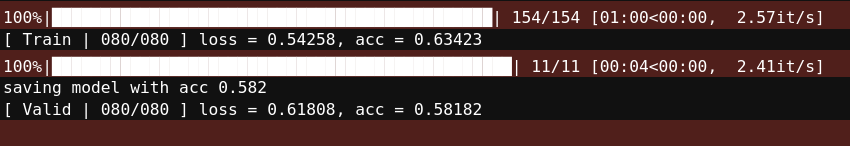

### Medium
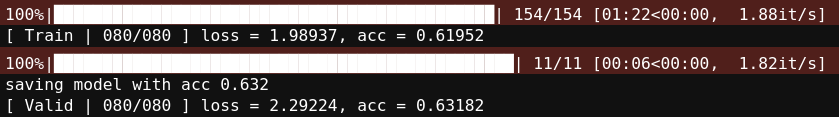

### Strong
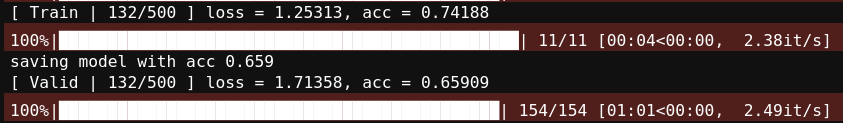

## **Testing** *(same as HW3)*

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

### **WARNING -- Keep in Mind**

Cheating includes but not limited to:
1.   using testing labels,
2.   submitting results to previous Kaggle competitions,
3.   sharing predictions with others,
4.   copying codes from any creatures on Earth,
5.   asking other people to do it for you.

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules.
When citing codes from the Internet, you should know what these codes exactly do.
You will **NOT** be tolerated if you break the rule and claim you don't know what these codes do.


In [12]:
### This block is same as HW3 ###
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
student_net.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = student_net(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/53 [00:00<?, ?it/s]

In [13]:
### This block is same as HW3 ###
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")